# Data pre-processing

### Notebook written by Matteo Sesia
#### Stanford University, Department of Statistics
#### Last updated on: May 10, 2019

The purpose of this notebook is to discuss some data preprocessing steps that may be useful before using the `DeepKnockoff` package. In particular, we will talk about how to deal with extremely correlated variables that would result in knockoffs having no power.

For now, we follow the strategy described in this paper: "*Panning for Gold: Model-X Knockoffs for High-dimensional Controlled Variable Selection*",
E. Candès, Y. Fan, L. Janson, and J. Lv. J. R. Stat. Soc. B. (2018). [https://arxiv.org/abs/1610.02351](https://arxiv.org/abs/1610.02351). We may explore more sophisticated approaches in the future.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as spc
import data
import parameters

## Data generating model

We model the distribution of $X \in \mathbb{R}^p $ as multivariate Gaussian, with $p=100$ and the covariance matrix of an auto-regressive process of order one. We choose the correlation parameter equal to $\rho =0.95$.

In [2]:
# Number of features
p = 500

# Define the model for X
DataSampler = data.GaussianAR1(p, 0.95)

In [3]:
# Number of training examples
n = 2000

# Sample training data
X_train = DataSampler.sample(n)
print("Generated a training dataset of size: %d x %d." %(X_train.shape))

Generated a training dataset of size: 2000 x 500.


## Compute correlations

In [4]:
# Compute covariance matrix
SigmaHat = np.cov(X_train, rowvar=False)
# Compute correlation matrix
SigmaHat = data.cov2cor(SigmaHat)

We can visualize the correlation matrix as a heatmap.

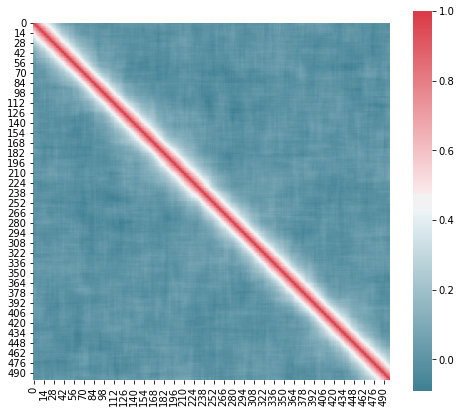

In [5]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(SigmaHat, cmap=cmap, square=True)

## Hierarchical clustering

We apply hierarchical clustering to the correlation matrix. In this case, we choose average-linkage clustering, although other options may be better suited in different scenarios.

In [6]:
# Compute distance between variables based on their pairwise absolute correlations
pdist = spc.distance.squareform(1-np.abs(SigmaHat))

# Apply average-linkage hierarchical clustering
linkage = spc.linkage(pdist, method='average')

Next, we group the variables into highly-correlated blocks and keep only one representative from each blocks.
To ensure that the typical remaining correlations are below the (arbitrary) target level ($\rho_\max=0.7$), we cut the dendrogram at height $d_\max=1- \rho_\max=0.3$.

In [7]:
corr_max = 0.7
d_max = 1-corr_max

Let's now plot the clustering dendrogram and visualize the groups corresponding to the cut defined above.

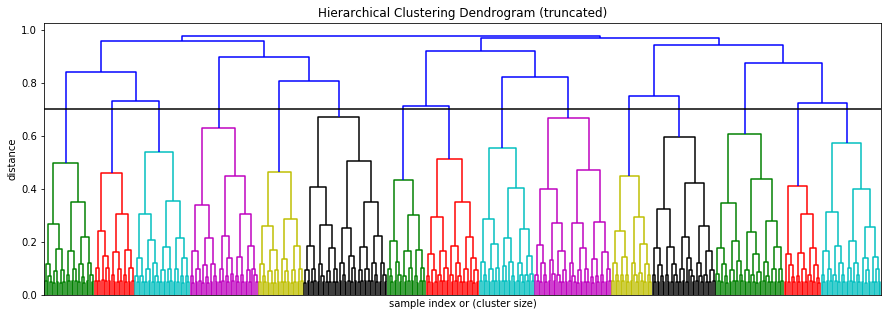

In [8]:
def fancy_dendrogram(*args, **kwargs):
    """From: 
    https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    """
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = spc.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 5))

# Plot dendrogram
fancy_dendrogram(
    linkage,
    max_d=1-d_max,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    no_labels=True,
)
plt.show()

Let's now extract the groups shown above.

In [9]:
# Cut the dendrogram and define the groups of variables
groups = spc.cut_tree(linkage, height=d_max).flatten()
print("Divided " + str(len(groups)) + " variables into "+str(np.max(groups)+1) + " groups.")

# Plot group sizes
_, counts = np.unique(groups, return_counts=True)
print("Size of largest groups: "+str(np.max(counts)))
print("Mean groups size: "+str(np.mean(counts)))

Divided 500 variables into 52 groups.
Size of largest groups: 14
Mean groups size: 9.615384615384615


## Pick group representatives

The final pre-processing step is to pick one variable as representative from each group. For simplicity, here we pick the first variable in each group (in the arbitrary order defined by the the "groups" vector).

In [10]:
# Pick one representative for each cluster
representatives = np.array([np.where(groups==g)[0][0] for g in np.arange(np.max(groups))])
# Print list of group representatives
representatives

array([  0,   7,  17,  30,  38,  48,  54,  63,  70,  77,  87,  94, 104,
       112, 118, 128, 136, 146, 157, 170, 178, 192, 205, 219, 229, 237,
       246, 253, 260, 271, 280, 293, 305, 313, 326, 339, 352, 363, 371,
       379, 389, 401, 410, 418, 431, 442, 450, 457, 466, 478, 485])

Now we can measure the remaining correlations among the group representatives

In [11]:
# Correlation matrix for group representatives
SigmaHat_repr = SigmaHat[representatives,:][:,representatives]

# Print largest remaining correlation
np.max(np.abs(SigmaHat_repr-np.eye(SigmaHat_repr.shape[0])))

0.7409786194709453

The correlation matrix for the group representatives looks as follows.

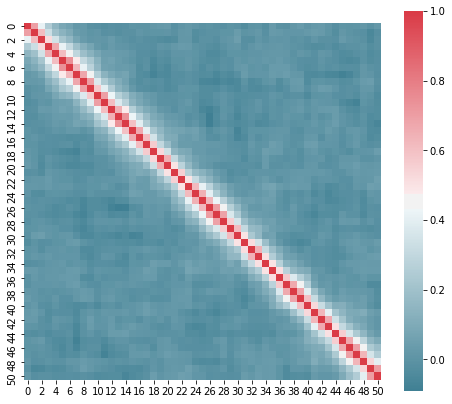

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Draw the heatmap
sns.heatmap(SigmaHat_repr, cmap=cmap, square=True)